# This notebook is edited from the original to use Finnish data
Most of the explanations have been removed. To see the full explanation and US data, check out the original notebook
https://github.com/k-sys/covid-19/blob/master/Realtime%20R0.ipynb

In [1]:
import pandas as pd
import numpy as np

from datetime import datetime as dt
from datetime import timedelta

from matplotlib import pyplot as plt
from matplotlib.dates import date2num, num2date
from matplotlib import dates as mdates
from matplotlib import ticker
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

from scipy import stats as sps
from scipy.interpolate import interp1d

from IPython.display import clear_output

%config InlineBackend.figure_format = 'retina'

In [2]:
# We create an array for every possible value of Rt
R_T_MAX = 12
r_t_range = np.linspace(0, R_T_MAX, R_T_MAX*100+1)

# Gamma is 1/serial interval
# https://wwwnc.cdc.gov/eid/article/26/6/20-0357_article
GAMMA = 1/4

# Skip last 5 days since the THL data is incomplete for the last few days
SKIP_N_LAST_DAYS_IN_DATA = 5
# How many days of history used as posterior
DAYS_USED_IN_POSTERIOR = 7

In [3]:
def highest_density_interval(pmf, p=.95):
    
    # If we pass a DataFrame, just call this recursively on the columns
    if(isinstance(pmf, pd.DataFrame)):
        return pd.DataFrame([highest_density_interval(pmf[col]) for col in pmf],
                            index=pmf.columns)
    
    cumsum = np.cumsum(pmf.values)
    best = None
    for i, value in enumerate(cumsum):
        for j, high_value in enumerate(cumsum[i+1:]):
            if (high_value-value > p) and (not best or j<best[1]-best[0]):
                best = (i, i+j+1)
                break
            
    low = pmf.index[best[0]]
    high = pmf.index[best[1]]
    return pd.Series([low, high], index=['Low', 'High'])

# Finland Data

In [4]:
import requests


def get_data_from_THL():
    url = "https://w3qa5ydb4l.execute-api.eu-west-1.amazonaws.com/prod/processedThlData"

    payload = ""
    response = requests.request("GET", url, data=payload)

    print(f'Response status: {response.status_code}')
    response_json = response.json()

    finland = pd.DataFrame(response_json['confirmed']['Kaikki sairaanhoitopiirit'])
    finland['date'] = finland['date'].apply(pd.to_datetime).dt.date
    finland.set_index(finland['date'], inplace=True)
    
    last_day = dt.today().date() - timedelta(SKIP_N_LAST_DAYS_IN_DATA)
    print(f'Use data before {last_day}')
    return finland[finland['date'] < last_day]

finland = get_data_from_THL()
finland

Response status: 200
Use data before 2020-04-18


,value,healthCareDistrict,date
date,,,
2020-01-01,0,Kaikki sairaanhoitopiirit,2020-01-01
2020-01-02,0,Kaikki sairaanhoitopiirit,2020-01-02
2020-01-03,0,Kaikki sairaanhoitopiirit,2020-01-03
2020-01-04,0,Kaikki sairaanhoitopiirit,2020-01-04
2020-01-05,0,Kaikki sairaanhoitopiirit,2020-01-05
...,...,...,...
2020-04-13,115,Kaikki sairaanhoitopiirit,2020-04-13
2020-04-14,170,Kaikki sairaanhoitopiirit,2020-04-14
2020-04-15,126,Kaikki sairaanhoitopiirit,2020-04-15


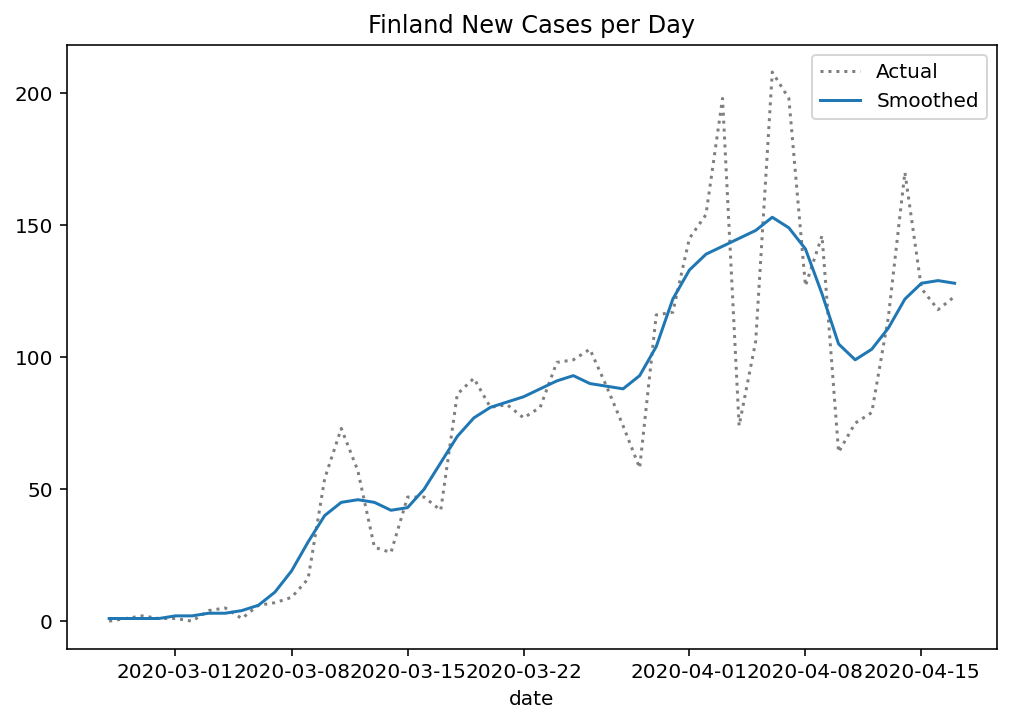

In [5]:
state_name = 'Finland'

def prepare_cases(new_cases):
    # Note that in the origal data, the cases were cumulative
    # The THL data is per day, so there is no need to take diff
    # new_cases = cases.diff()

    smoothed = new_cases.rolling(7,
        win_type='gaussian',
        min_periods=1,
        center=True).mean(std=2).round()
    
    zeros = smoothed.index[smoothed.eq(0)]
    if len(zeros) == 0:
        idx_start = 0
    else:
        last_zero = zeros.max()
        idx_start = smoothed.index.get_loc(last_zero) + 1
    smoothed = smoothed.iloc[idx_start:]
    original = new_cases.loc[smoothed.index]
    
    return original, smoothed

cases = finland['value'].rename(f"{state_name} cases")

original, smoothed = prepare_cases(cases)

original.plot(title=f"{state_name} New Cases per Day",
               c='k',
               linestyle=':',
               alpha=.5,
               label='Actual',
               legend=True,
             figsize=(600/72, 400/72))

ax = smoothed.plot(label='Smoothed',
                   legend=True)
ax.get_figure().set_facecolor('w')

### Running the Algorithm

Just like the example before, we create lambda based on the previous day's counts from all values of $R_t$. Unlike the previous example, I now evaluate the __log__ of the Poisson. Why? It makes windowing easier.

Since $\log{ab}=\log{a}+\log{b}$, we can do a rolling sum over the last $m$ periods and then exponentiate to get the rolling product of the original values. This does not change any of the numbers – it's just a convenience.

In [6]:
def get_posteriors(sr, min_periods=1):
    window=DAYS_USED_IN_POSTERIOR
    lam = sr[:-1].values * np.exp(GAMMA * (r_t_range[:, None] - 1))

    # Note: if you want to have a Uniform prior you can use the following line instead.
    # I chose the gamma distribution because of our prior knowledge of the likely value
    # of R_t.
    
    # prior0 = np.full(len(r_t_range), np.log(1/len(r_t_range)))
    
    prior0 = np.log(sps.gamma(a=3).pdf(r_t_range) + 1e-14)

    likelihoods = pd.DataFrame(
        # Short-hand way of concatenating the prior and likelihoods
        data = np.c_[prior0, sps.poisson.logpmf(sr[1:].values, lam)],
        index = r_t_range,
        columns = sr.index)

    # Perform a rolling sum of log likelihoods. This is the equivalent
    # of multiplying the original distributions. Exponentiate to move
    # out of log.
    posteriors = likelihoods.rolling(window,
                                     axis=1,
                                     min_periods=min_periods).sum()
    posteriors = np.exp(posteriors)

    # Normalize to 1.0
    posteriors = posteriors.div(posteriors.sum(axis=0), axis=1)
    
    return posteriors

posteriors = get_posteriors(smoothed)

### The Result

Below you can see every day (row) of the posterior distribution plotted simultaneously. The posteriors start without much confidence (wide) and become progressively more confident (narrower) about the true value of $R_t$

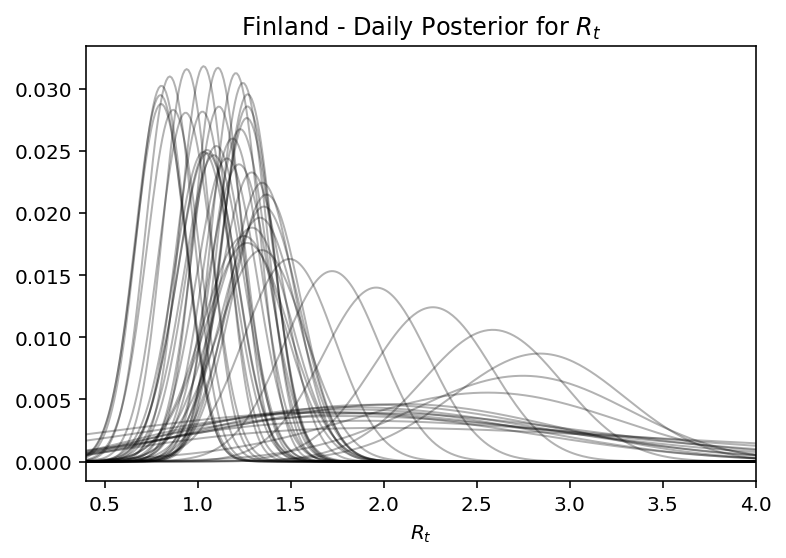

In [7]:
ax = posteriors.plot(title=f'{state_name} - Daily Posterior for $R_t$',
           legend=False, 
           lw=1,
           c='k',
           alpha=.3,
           xlim=(0.4,4))

ax.set_xlabel('$R_t$');

### Plotting in the Time Domain with Credible Intervals

Since our results include uncertainty, we'd like to be able to view the most likely value of $R_t$ along with its highest-density interval.

In [8]:
# Note that this takes a while to execute - it's not the most efficient algorithm
hdis = highest_density_interval(posteriors)

most_likely = posteriors.idxmax().rename('ML')

# Look into why you shift -1
result = pd.concat([most_likely, hdis], axis=1)

result.tail()

,ML,Low,High
date,,,
2020-04-13,0.80,0.54,1.09
2020-04-14,0.87,0.60,1.16
2020-04-15,0.93,0.66,1.22
2020-04-16,1.03,0.75,1.31
2020-04-17,1.11,0.84,1.39


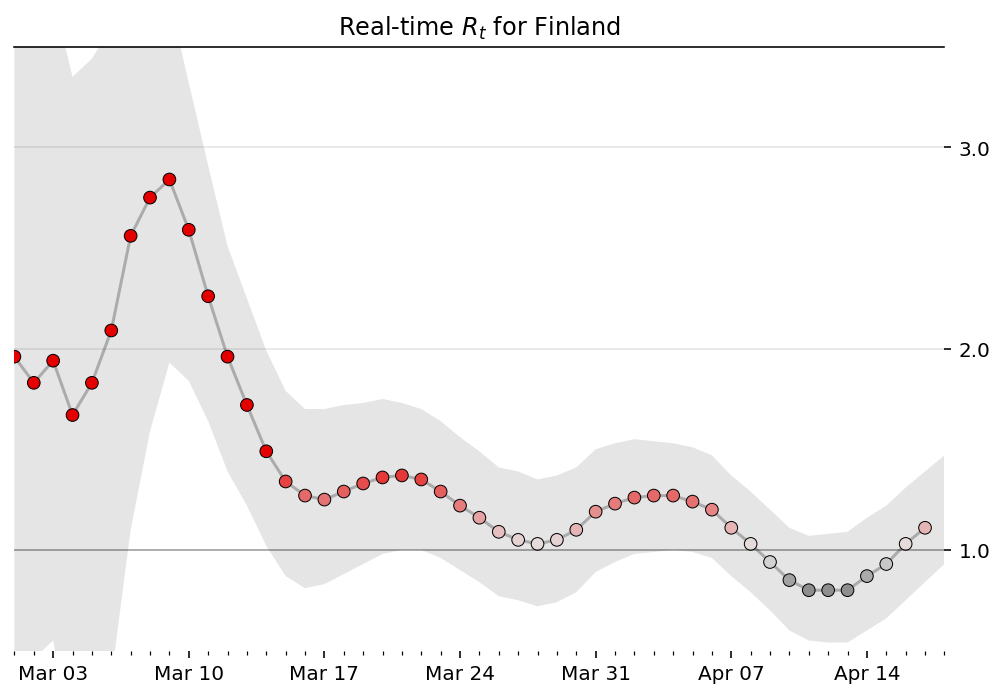

In [9]:
def plot_rt(result, ax, state_name):
    
    ax.set_title(f"{state_name}")
    
    # Colors
    ABOVE = [1,0,0]
    MIDDLE = [1,1,1]
    BELOW = [0,0,0]
    cmap = ListedColormap(np.r_[
        np.linspace(BELOW,MIDDLE,25),
        np.linspace(MIDDLE,ABOVE,25)
    ])
    color_mapped = lambda y: np.clip(y, .5, 1.5)-.5
    
    index = result['ML'].index.get_level_values('date')
    values = result['ML'].values
    
    # Plot dots and line
    ax.plot(index, values, c='k', zorder=1, alpha=.25)
    ax.scatter(index,
               values,
               s=40,
               lw=.5,
               c=cmap(color_mapped(values)),
               edgecolors='k', zorder=2)
    
    # Aesthetically, extrapolate credible interval by 1 day either side
    lowfn = interp1d(date2num(index),
                     result['Low'].values,
                     bounds_error=False,
                     fill_value='extrapolate')
    
    highfn = interp1d(date2num(index),
                      result['High'].values,
                      bounds_error=False,
                      fill_value='extrapolate')
    
    extended = pd.date_range(start=pd.Timestamp('2020-03-01'),
                             end=index[-1]+pd.Timedelta(days=1))
    
    ax.fill_between(extended,
                    lowfn(date2num(extended)),
                    highfn(date2num(extended)),
                    color='k',
                    alpha=.1,
                    lw=0,
                    zorder=3)

    ax.axhline(1.0, c='k', lw=1, label='$R_t=1.0$', alpha=.25);
    
    # Formatting
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.xaxis.set_minor_locator(mdates.DayLocator())
    
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
    ax.yaxis.tick_right()
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.margins(0)
    ax.grid(which='major', axis='y', c='k', alpha=.1, zorder=-2)
    ax.margins(0)
    ax.set_ylim(0.0,3.5)
    ax.set_xlim(pd.Timestamp('2020-03-01'), result.index.get_level_values('date')[-1]+pd.Timedelta(days=1))
    fig.set_facecolor('w')

    
fig, ax = plt.subplots(figsize=(600/72,400/72))

plot_rt(result, ax, state_name)
ax.set_title(f'Real-time $R_t$ for {state_name}')
ax.set_ylim(.5,3.5)
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))